<a href="https://colab.research.google.com/github/gabrieladamasceno/Attacks_5G/blob/main/Catboost_All_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Acessar dataset
drive.mount('/content/gdrive')

# Carregar o dataset
encoded = pd.read_csv("/content/gdrive/MyDrive/Datasets/Attacks/Encoded/Encoded.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [42]:
pip install imbalanced-learn


In [43]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

In [44]:
!pip install gputil


In [45]:
# Selecionar apenas colunas numéricas
numeric_cols = encoded.select_dtypes(include=['number']).columns

# Aplicar a suavização apenas nas colunas numéricas
for col in numeric_cols:
    encoded[col] = encoded[col].fillna(encoded[col].mean())

In [46]:
# columns with null values

columns_null = []
columns = encoded.columns
for column in columns:
    c = encoded[column].isnull().sum()
    if c != 0:
        print(column, 'has {} null values'.format(c))
        columns_null.append(column)

In [47]:
import psutil
import time
import numpy as np
import pandas as pd
import gc
import tensorflow as tf
import subprocess
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K

# ===== Função para monitorar CPU e memória =====
def monitor_resource_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    cpu_percent = psutil.cpu_percent(interval=0.1)
    memory_usage_mb = memory_info.rss / (1024 * 1024)
    return cpu_percent, memory_usage_mb

def calcular_energia(cpu_usage, freq_ghz, tempo_exec_s, theta=1.0, z=1e-27):
    freq_hz = freq_ghz * 1e9
    carga = cpu_usage * theta * freq_hz
    energia_joules = z * (carga ** 3) * tempo_exec_s
    return energia_joules

# ===== Callback para monitoramento durante o treinamento =====
class ResourceMonitor(Callback):
    def on_train_begin(self, logs=None):
        self.cpu_usage = []
        self.memory_usage = []
        self.energy_usage = []
        self.start_time = time.time()
        print("\n[Início do Treinamento]")

    def on_epoch_begin(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        print(f"\n[Epoch {epoch + 1} - Início] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB")

    def on_epoch_end(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        frequencia_cpu_ghz = 2.0
        tempo_execucao_epoca = time.time() - self.start_time
        #energy = calcular_energia(cpu, frequencia_cpu_ghz, tempo_execucao_epoca)
        #self.energy_usage.append(energy)
        print(f"[Epoch {epoch + 1} - Fim] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB")

        # Limpeza de recursos
        gc.collect()
        K.clear_session()

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        avg_cpu = np.mean(self.cpu_usage)
        avg_mem = np.mean(self.memory_usage)

        frequencia_cpu_ghz = 2.0

        # Cálculo de energia corrigido
        energia = calcular_energia(avg_cpu, frequencia_cpu_ghz, total_time)

        print("\n[End of Training]")
        print(f"Total time: {total_time:.2f} seconds")
        print(f"Average CPU usage (Training): {avg_cpu:.2f}%")
        print(f"Average memory usage (Training): {avg_mem:.2f} MB")
        print(f"Estimated energy consumption: {energia:.2f} Joules")

        # Armazenar para uso externo
        self.total_time = total_time
        self.avg_cpu = avg_cpu
        self.avg_mem = avg_mem
        self.energia = energia

        self._plot_usage()

    def _plot_usage(self):
        epochs = list(range(1, len(self.cpu_usage) + 1))

        plt.figure(figsize=(14, 5))

        # CPU
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.cpu_usage, marker='o', linestyle='-', color='tab:blue', label='CPU Usage')
        plt.xlabel("Epoch")
        plt.ylabel("CPU Usage (%)")
        plt.title("CPU Consumption (Train)")
        plt.legend()
        plt.grid(True)

        # Memória
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.memory_usage, marker='o', linestyle='-', color='tab:red', label='Memory Usage')
        plt.xlabel("Epoch")
        plt.ylabel("Memory (MB)")
        plt.title("Memory Consumption (Train)")
        plt.legend()
        plt.grid(True)


        plt.tight_layout()
        plt.savefig("resource_usage_train.png")
        plt.show()
        plt.clf()
        plt.close()


# ===== Monitoramento durante o teste/predição =====
def monitor_test_prediction(model, X_test):
    cpu_usage_test = []
    memory_usage_test = []

    print("\n[Início da Predição/Teste]")
    start_time = time.time()

    step_size = max(1, len(X_test) // 10)
    for i in range(0, len(X_test), step_size):
        end_i = min(i + step_size, len(X_test))
        monitor_cpu, monitor_mem = monitor_resource_usage()
        cpu_usage_test.append(monitor_cpu)
        memory_usage_test.append(monitor_mem)
        _ = model.predict(X_test[i:end_i], verbose=0)

    total_time_test = time.time() - start_time
    avg_cpu_test = np.mean(cpu_usage_test)
    avg_mem_test = np.mean(memory_usage_test)

    frequencia_cpu_ghz = 2.0

    # Cálculo de energia
    energia_test = calcular_energia(avg_cpu_test, frequencia_cpu_ghz, total_time_test)

    print("\n[End of Prediction/Test]")
    print(f"Total time: {total_time_test:.2f} seconds")
    print(f"Average CPU usage (Test): {avg_cpu_test:.2f}%")
    print(f"Average memory usage (Test): {avg_mem_test:.2f} MB")
    print(f"Estimated energy consumption: {energia_test:.2f} Joules")

    # Gráficos
    plt.figure(figsize=(14, 5))

    # CPU
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(cpu_usage_test) + 1), cpu_usage_test, marker='o', linestyle='-', color='tab:blue', label='CPU Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("CPU Usage (%)")
    plt.title("CPU Consumption (Test)")
    plt.legend()
    plt.grid(True)

    # Memória
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(memory_usage_test) + 1), memory_usage_test, marker='o', linestyle='-', color='tab:red', label='Memory Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("Memory (MB)")
    plt.title("Memory Consumption (Test)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("resource_usage_test.png")
    plt.show()
    plt.clf()
    plt.close()

    return {
    'total_time': total_time_test,
    'avg_cpu': avg_cpu_test,
    'avg_mem': avg_mem_test,
    'energia': energia_test
    }

resource_monitor = ResourceMonitor()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [48]:
pip install catboost


====== Zero-Day: ICMPFlood ======
Total ICMPFlood no dataset original: 1155
  em X_train antes da remoção: 917
  em X_test antes: 238
  moved_to_test (vai mover): 917
  test_zero (já no teste): 238
  Zero-Day combined total: 1155 (duplicadas exatas: 0)
  Test full total: 244095


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 2.66 seconds
Average CPU usage (Test): 1.02%
Average memory usage (Test): 4151.14 MB
Estimated energy consumption: 22.48 Joules


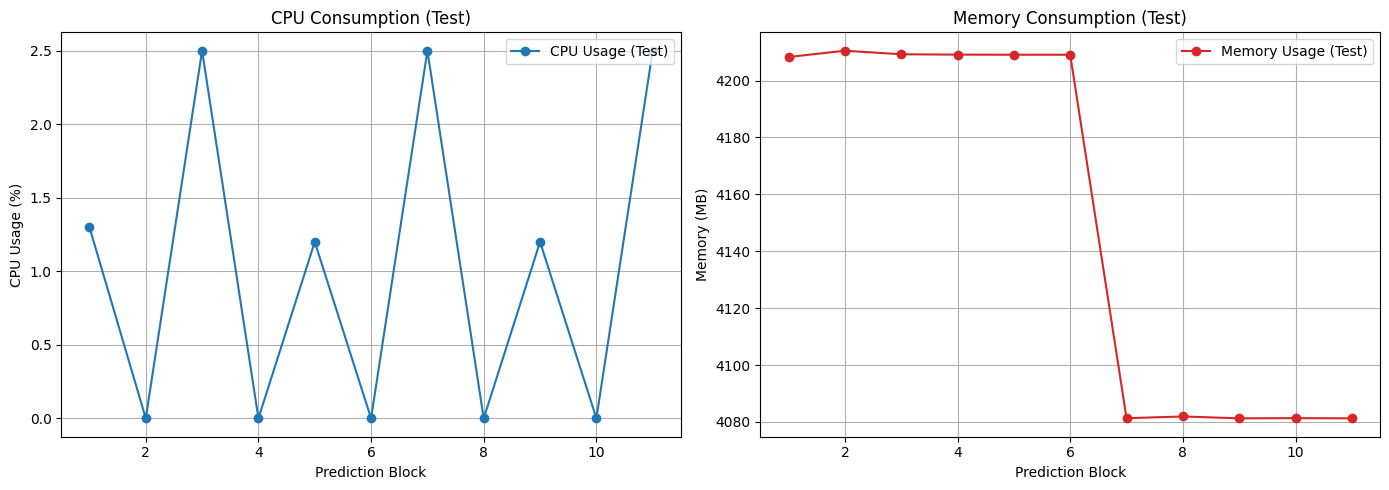

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.13 seconds
Average CPU usage (Test): 0.45%
Average memory usage (Test): 4052.49 MB
Estimated energy consumption: 0.80 Joules


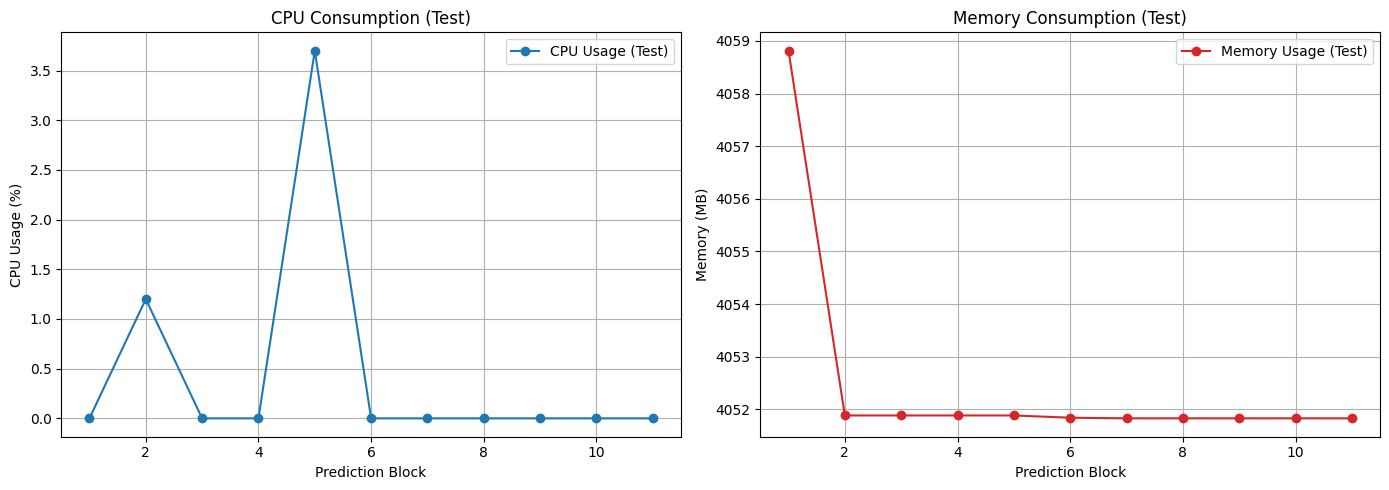

✅ Curva ROC (FULL) gerada para ICMPFlood — AUC=1.0000

====== Zero-Day: UDPFlood ======
Total UDPFlood no dataset original: 457340
  em X_train antes da remoção: 365919
  em X_test antes: 91421
  moved_to_test (vai mover): 365919
  test_zero (já no teste): 91421
  Zero-Day combined total: 457340 (duplicadas exatas: 0)
  Test full total: 609097


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 4.83 seconds
Average CPU usage (Test): 3.43%
Average memory usage (Test): 3916.18 MB
Estimated energy consumption: 1555.95 Joules


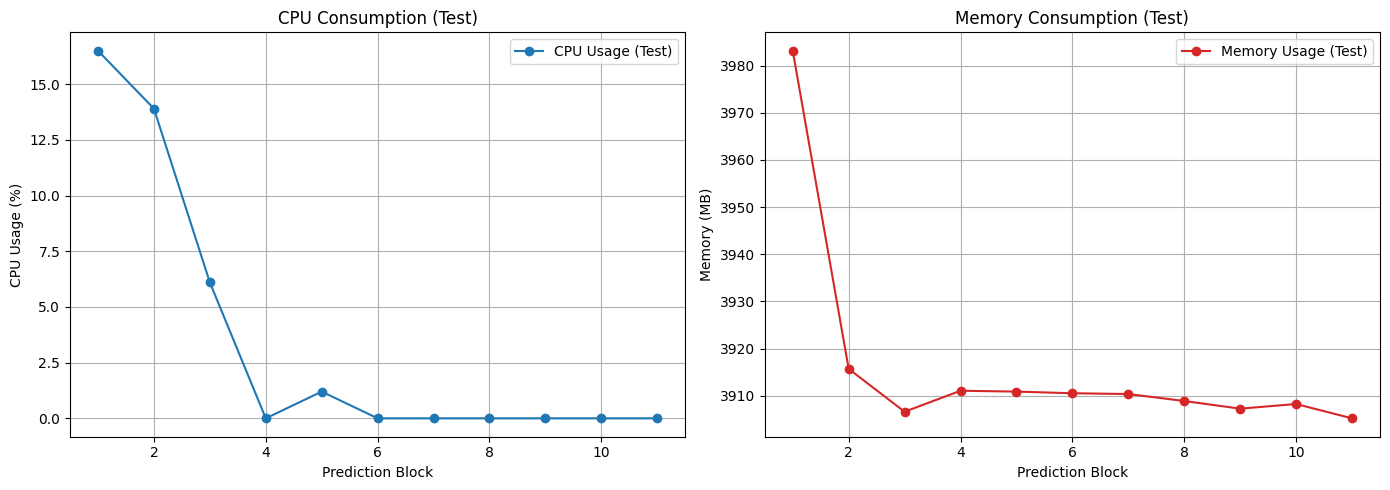

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.79 seconds
Average CPU usage (Test): 0.50%
Average memory usage (Test): 3901.82 MB
Estimated energy consumption: 3.79 Joules


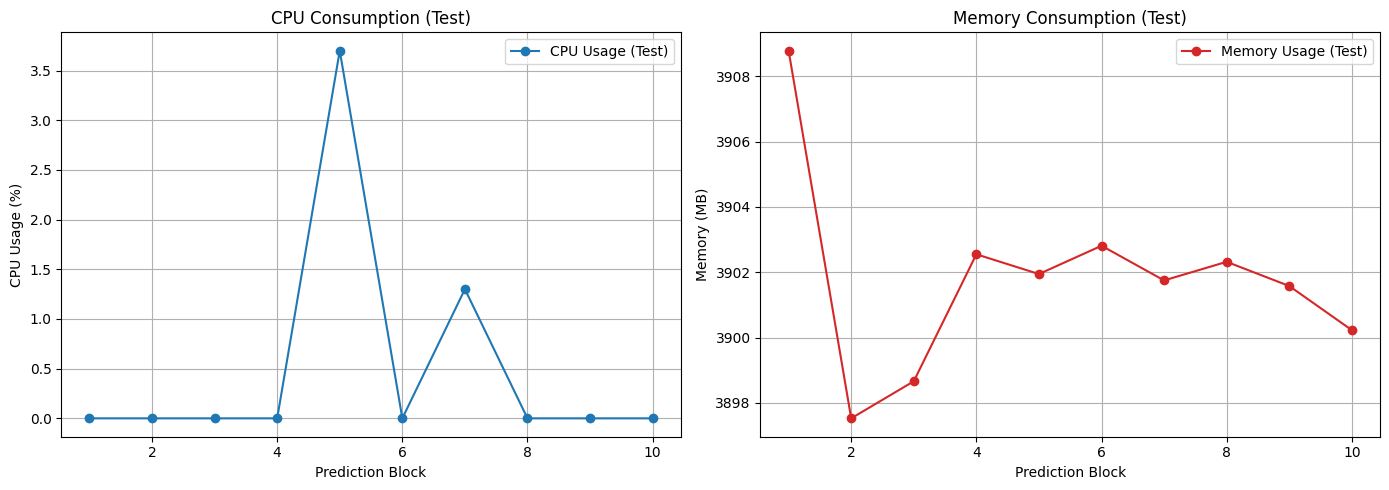

✅ Curva ROC (FULL) gerada para UDPFlood — AUC=0.9358

====== Zero-Day: SYNFlood ======
Total SYNFlood no dataset original: 9721
  em X_train antes da remoção: 7802
  em X_test antes: 1919
  moved_to_test (vai mover): 7802
  test_zero (já no teste): 1919
  Zero-Day combined total: 9721 (duplicadas exatas: 0)
  Test full total: 250980


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 2.65 seconds
Average CPU usage (Test): 9.36%
Average memory usage (Test): 4116.82 MB
Estimated energy consumption: 17366.26 Joules


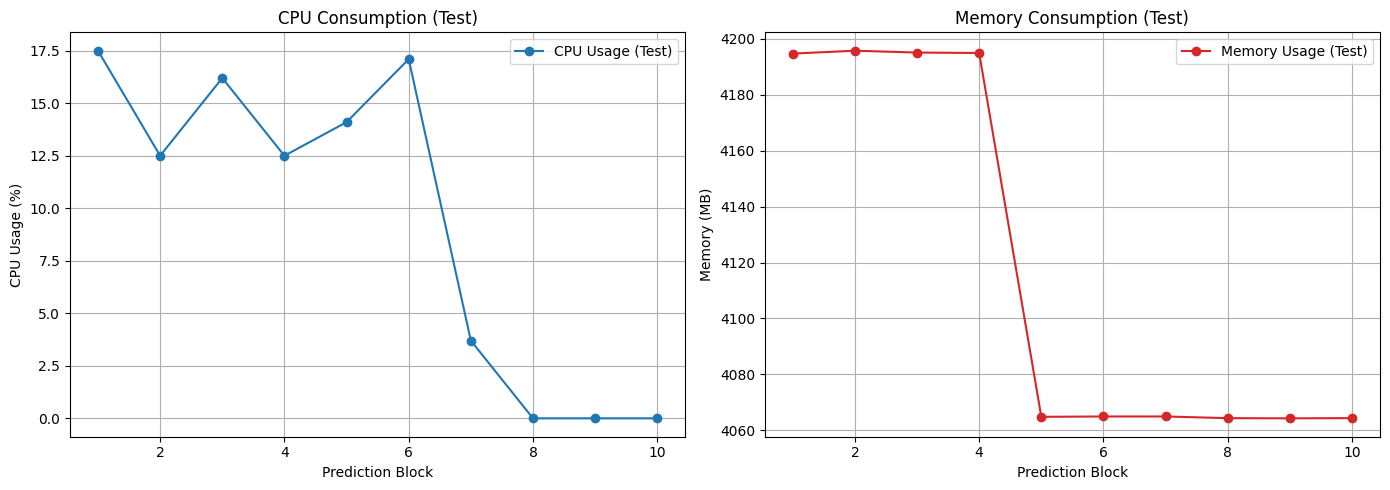

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.20 seconds
Average CPU usage (Test): 1.25%
Average memory usage (Test): 4044.75 MB
Estimated energy consumption: 18.91 Joules


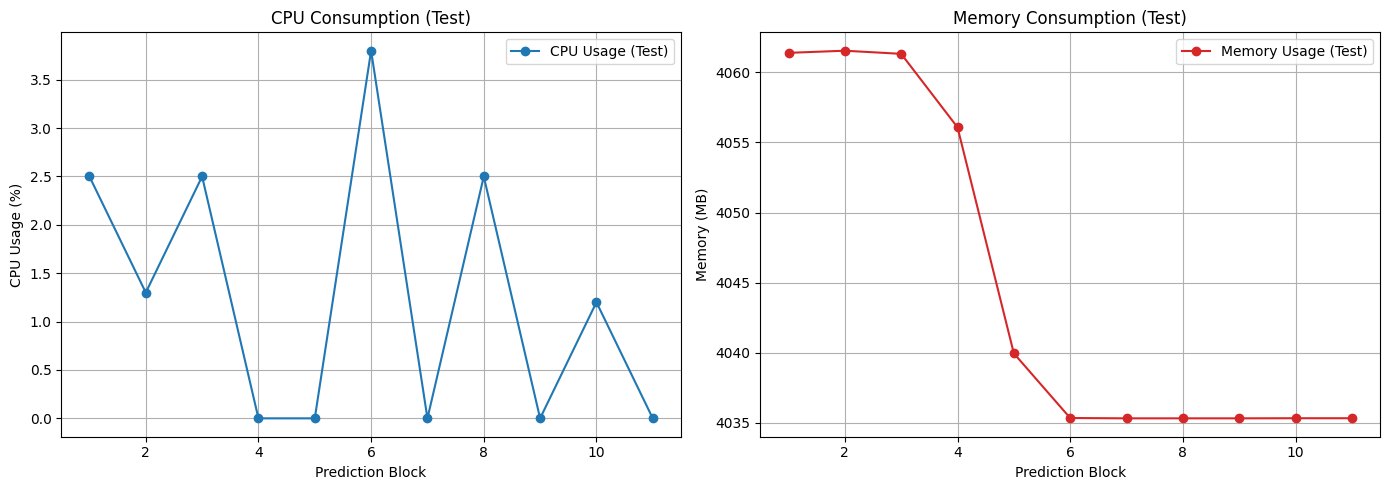

✅ Curva ROC (FULL) gerada para SYNFlood — AUC=0.9987

====== Zero-Day: SYNScan ======
Total SYNScan no dataset original: 20043
  em X_train antes da remoção: 16149
  em X_test antes: 3894
  moved_to_test (vai mover): 16149
  test_zero (já no teste): 3894
  Zero-Day combined total: 20043 (duplicadas exatas: 0)
  Test full total: 259327


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 2.70 seconds
Average CPU usage (Test): 1.81%
Average memory usage (Test): 4076.45 MB
Estimated energy consumption: 127.76 Joules


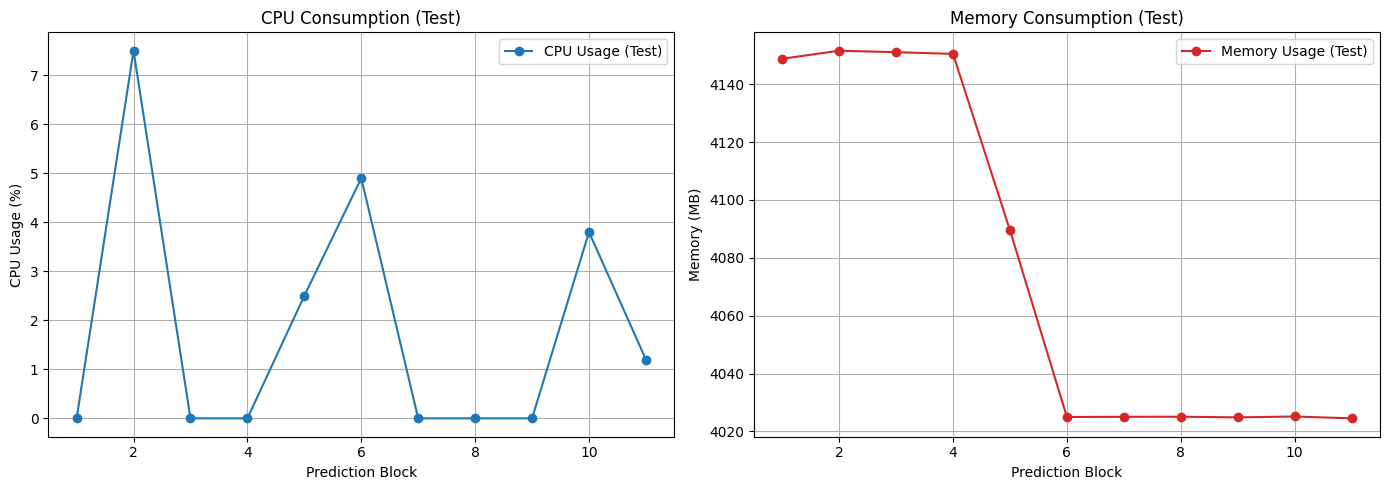

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.26 seconds
Average CPU usage (Test): 1.46%
Average memory usage (Test): 4007.08 MB
Estimated energy consumption: 31.63 Joules


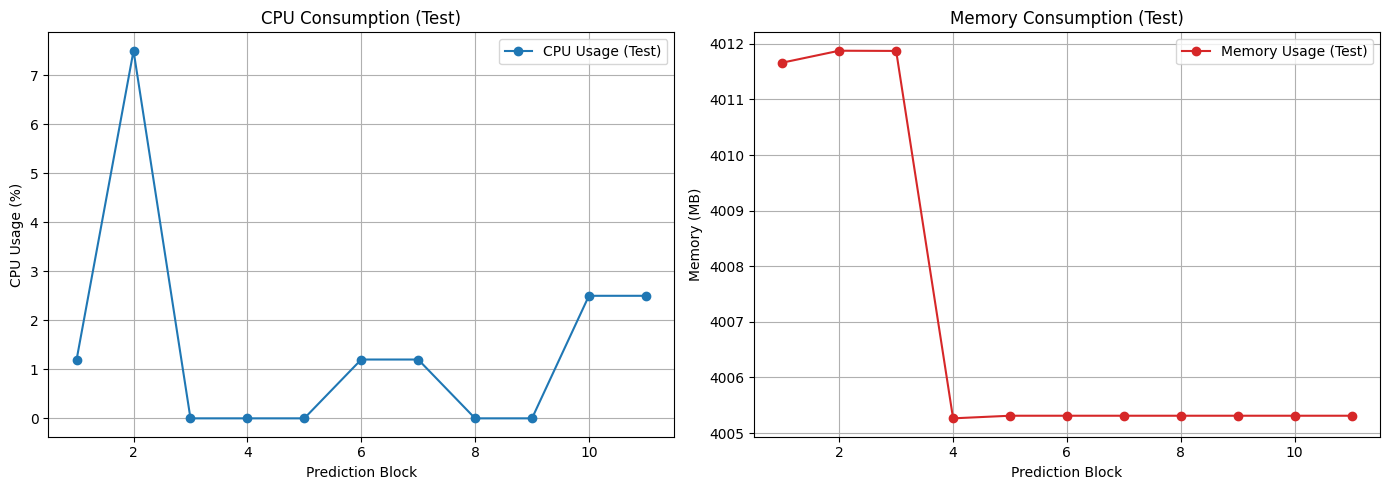

✅ Curva ROC (FULL) gerada para SYNScan — AUC=1.0000

====== Zero-Day: HTTPFlood ======
Total HTTPFlood no dataset original: 140812
  em X_train antes da remoção: 112649
  em X_test antes: 28163
  moved_to_test (vai mover): 112649
  test_zero (já no teste): 28163
  Zero-Day combined total: 140812 (duplicadas exatas: 0)
  Test full total: 355827


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.28 seconds
Average CPU usage (Test): 6.89%
Average memory usage (Test): 3848.37 MB
Estimated energy consumption: 8589.00 Joules


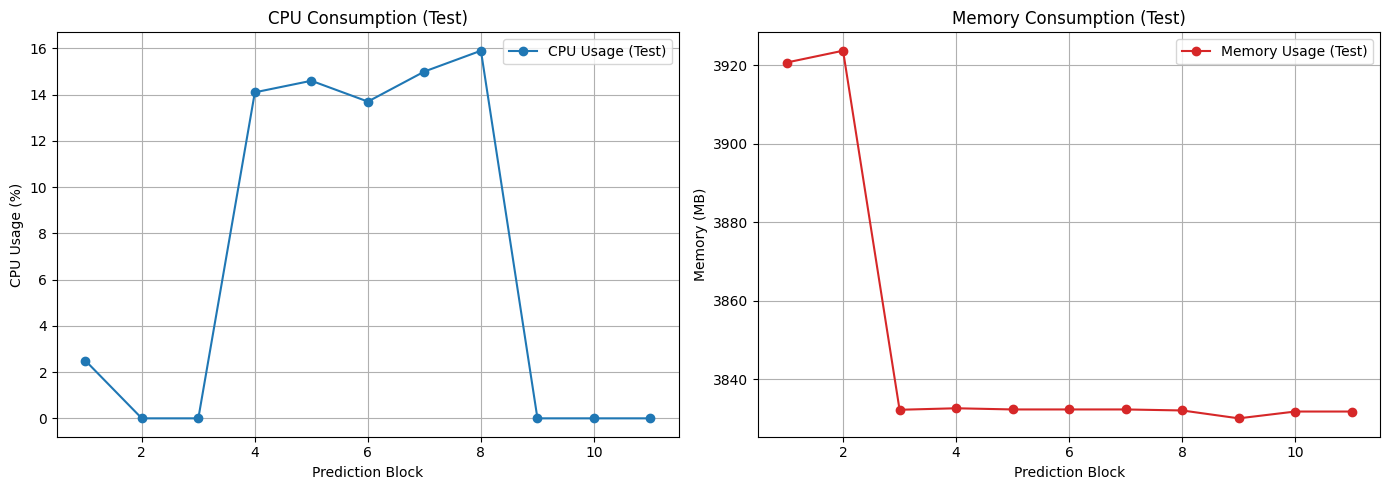

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.98 seconds
Average CPU usage (Test): 0.78%
Average memory usage (Test): 3813.69 MB
Estimated energy consumption: 7.59 Joules


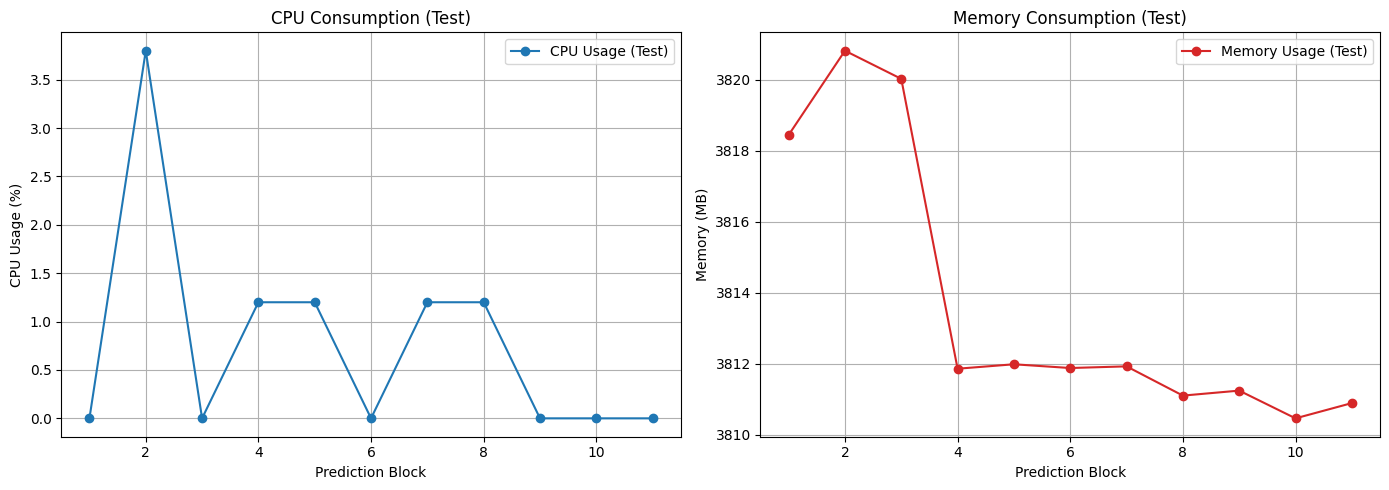

✅ Curva ROC (FULL) gerada para HTTPFlood — AUC=1.0000

====== Zero-Day: UDPScan ======
Total UDPScan no dataset original: 15906
  em X_train antes da remoção: 12713
  em X_test antes: 3193
  moved_to_test (vai mover): 12713
  test_zero (já no teste): 3193
  Zero-Day combined total: 15906 (duplicadas exatas: 0)
  Test full total: 255891


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 2.74 seconds
Average CPU usage (Test): 0.56%
Average memory usage (Test): 4125.41 MB
Estimated energy consumption: 3.92 Joules


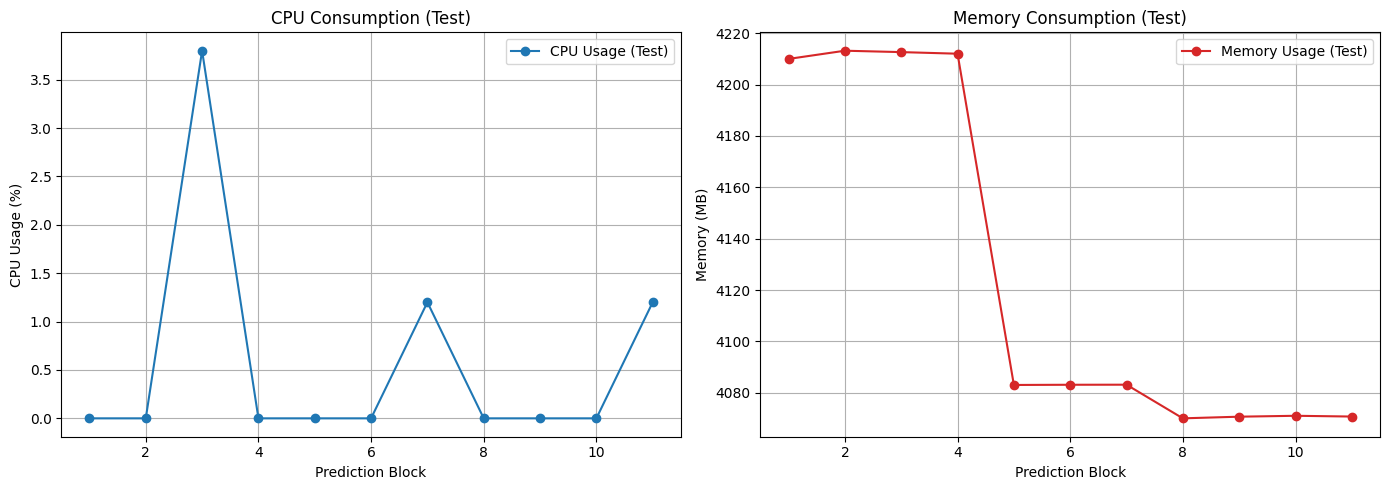

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.24 seconds
Average CPU usage (Test): 1.01%
Average memory usage (Test): 4063.91 MB
Estimated energy consumption: 10.19 Joules


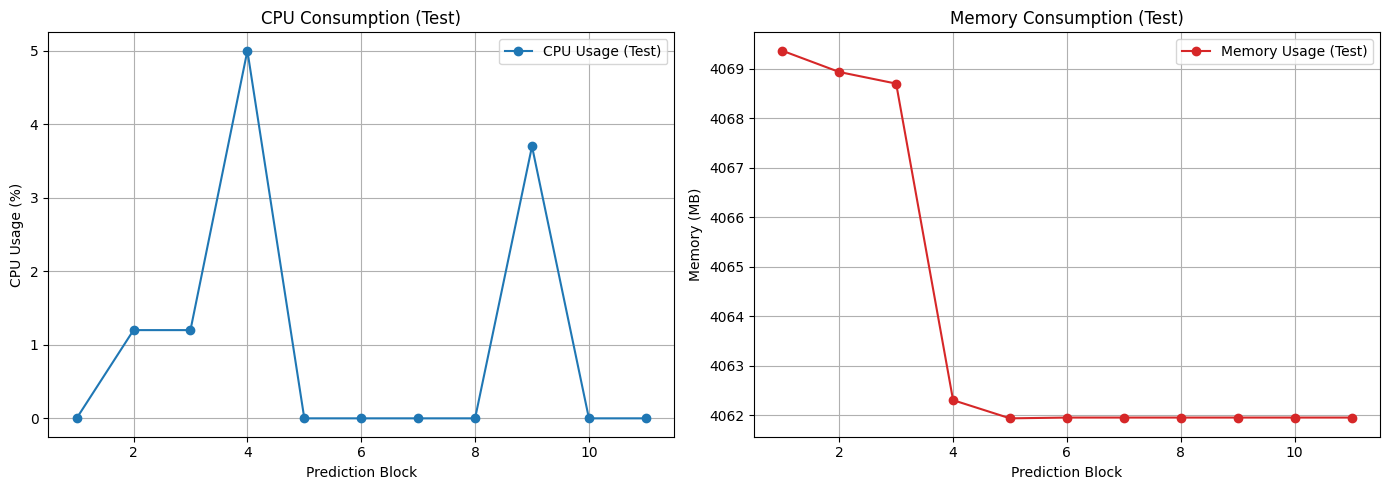

✅ Curva ROC (FULL) gerada para UDPScan — AUC=1.0000

====== Zero-Day: TCPConnectScan ======
Total TCPConnectScan no dataset original: 20052
  em X_train antes da remoção: 15999
  em X_test antes: 4053
  moved_to_test (vai mover): 15999
  test_zero (já no teste): 4053
  Zero-Day combined total: 20052 (duplicadas exatas: 0)
  Test full total: 259177


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 2.69 seconds
Average CPU usage (Test): 1.12%
Average memory usage (Test): 4133.51 MB
Estimated energy consumption: 30.03 Joules


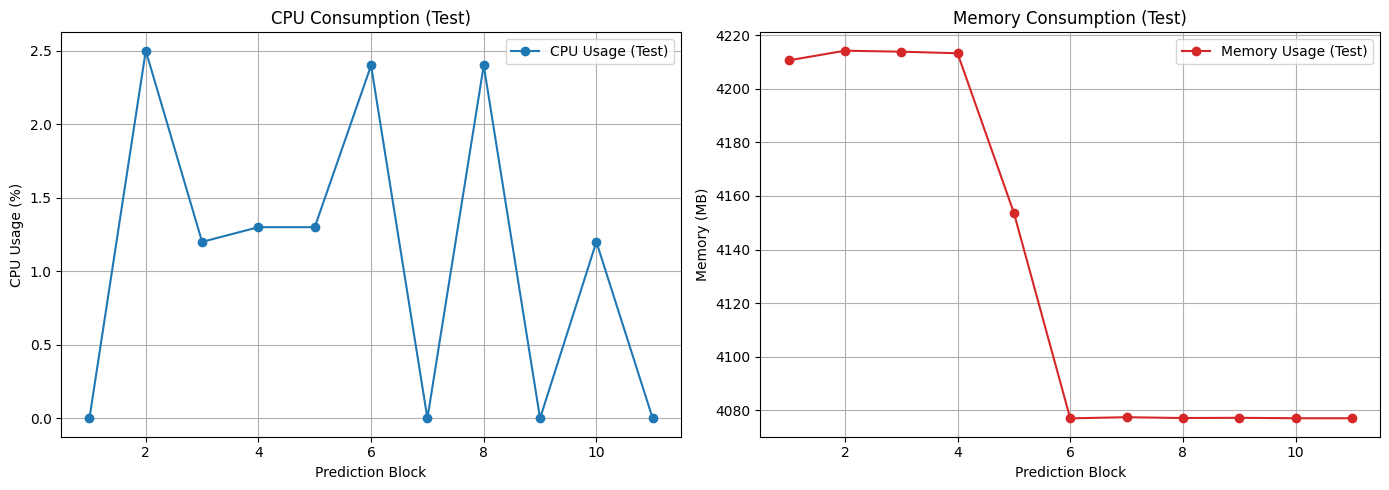

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.26 seconds
Average CPU usage (Test): 7.72%
Average memory usage (Test): 4068.96 MB
Estimated energy consumption: 4638.01 Joules


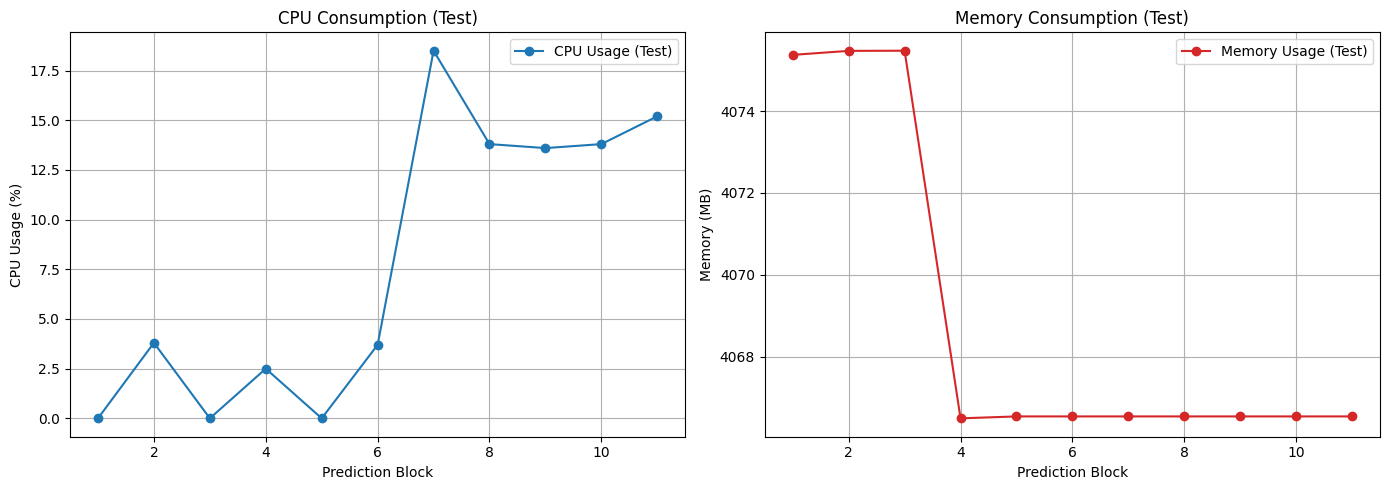

✅ Curva ROC (FULL) gerada para TCPConnectScan — AUC=1.0000

====== Zero-Day: SlowrateDoS ======
Total SlowrateDoS no dataset original: 73124
  em X_train antes da remoção: 58621
  em X_test antes: 14503
  moved_to_test (vai mover): 58621
  test_zero (já no teste): 14503
  Zero-Day combined total: 73124 (duplicadas exatas: 0)
  Test full total: 301799


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.01 seconds
Average CPU usage (Test): 0.68%
Average memory usage (Test): 4043.38 MB
Estimated energy consumption: 7.63 Joules


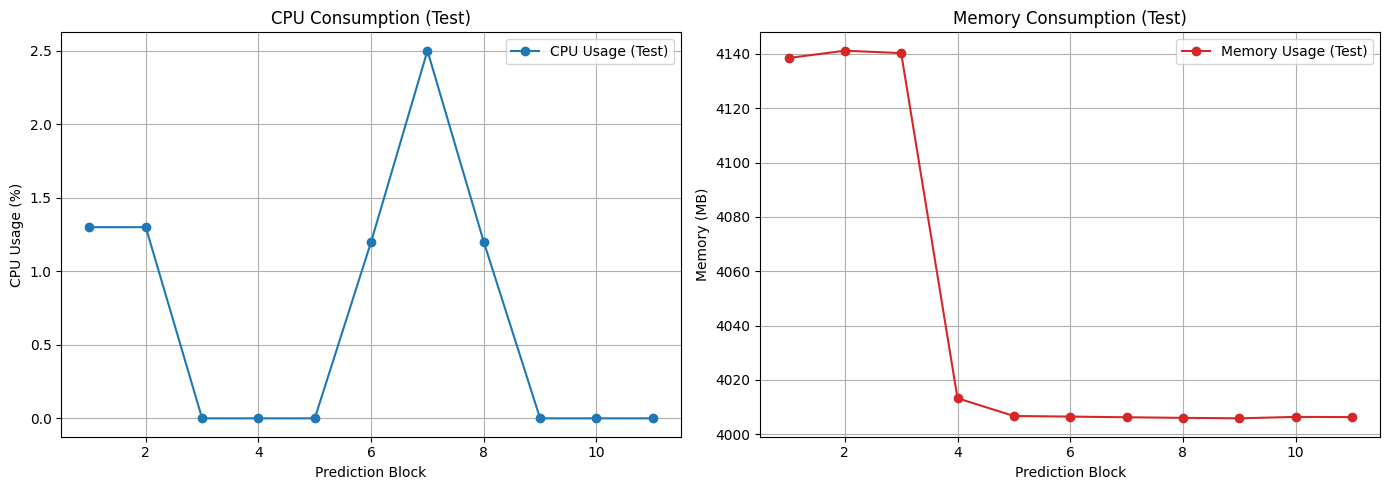

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 1.61 seconds
Average CPU usage (Test): 14.45%
Average memory usage (Test): 4010.97 MB
Estimated energy consumption: 38835.96 Joules


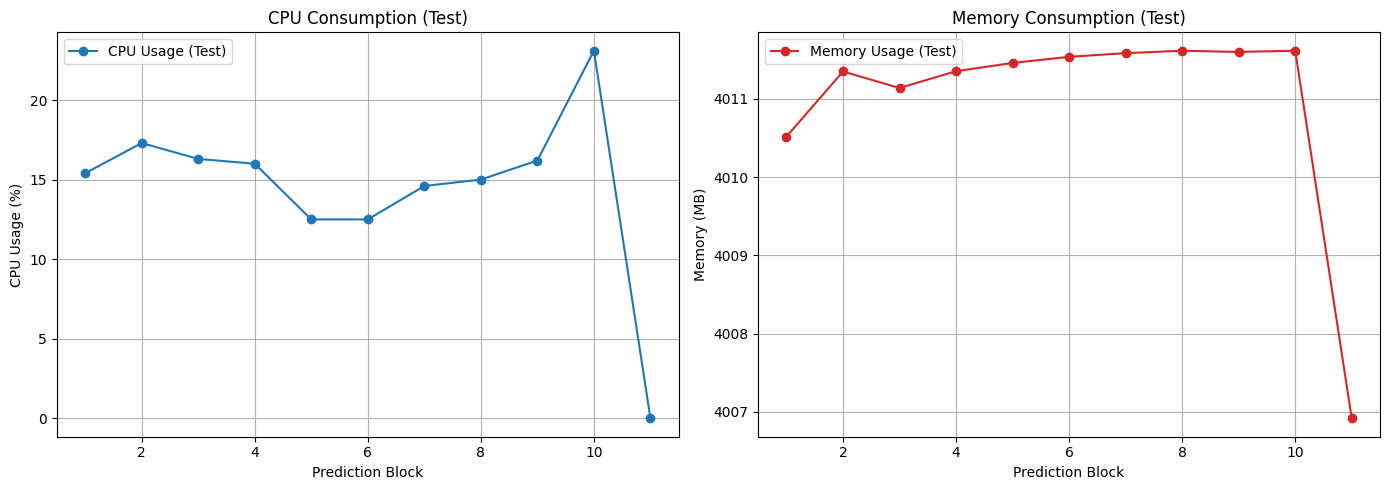

✅ Curva ROC (FULL) gerada para SlowrateDoS — AUC=1.0000


In [49]:
# ===== IMPORTS =====
import pandas as pd
import numpy as np
import time
import psutil
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os


# Configuração das features e rótulos
features = [
    'Seq', 'Offset', 'sTtl', 'tcp', 'AckDat', 'RST', 'INT', 'TcpRtt', 'icmp',
    'sMeanPktSz', 'FIN', 'sHops', 'Mean', 'dTtl', 'SrcBytes', 'TotBytes',
    'dMeanPktSz', 'Status', 'cs0', 'SrcWin', 'sTos', 'CON', 'REQ', 'Loss', 'Attack Type'
]

X = encoded[features]
y = encoded['Label']  # Coluna de rótulos

# Dividir antes de escolher zero-days
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Guardar Attack Type para separar os zero-days
X_train['Attack Type'] = encoded.loc[X_train.index, 'Attack Type']
X_test['Attack Type'] = encoded.loc[X_test.index, 'Attack Type']

# ===== CONFIGURAÇÕES =====
zero_day_attacks = ['ICMPFlood', 'UDPFlood', 'SYNFlood', 'SYNScan', 'HTTPFlood', 'UDPScan', 'TCPConnectScan', 'SlowrateDoS']  # Adapte para os ataques que você quiser testar
smote = SMOTE(random_state=42)
scaler = StandardScaler()
label_encoder = LabelEncoder()

resultados_zero_day = []

model_name = "CatBoost"
roc_full_curves = []

# ===== LOOP PRINCIPAL =====
resultados_zero_day = []

for ataque_zero_day in zero_day_attacks:
    print(f"\n====== Zero-Day: {ataque_zero_day} ======")

    # contagem global no dataset original (só pra referência)
    total_in_original = (X['Attack Type'] == ataque_zero_day).sum()
    print(f"Total {ataque_zero_day} no dataset original: {total_in_original}")

    # --- Separação dos dados ---
    train_indices = X_train[X_train['Attack Type'] != ataque_zero_day].index
    test_indices = X_test[X_test['Attack Type'] == ataque_zero_day].index

    # --- Amostras zero-day que estavam originalmente no treino (vai mover para o teste) ---
    moved_to_test = X_train.loc[X_train['Attack Type'] == ataque_zero_day].copy()
    moved_to_test_y = y_train.loc[moved_to_test.index].copy()

    # debug counts
    n_train_zero = len(moved_to_test)
    n_test_zero = len(test_indices)
    n_train_before = (X_train['Attack Type'] == ataque_zero_day).sum()
    n_test_before = (X_test['Attack Type'] == ataque_zero_day).sum()
    print(f"  em X_train antes da remoção: {n_train_before}")
    print(f"  em X_test antes: {n_test_before}")
    print(f"  moved_to_test (vai mover): {n_train_zero}")
    print(f"  test_zero (já no teste): {n_test_zero}")

    # --- Conjuntos limpos (sem o ataque zero-day no treino) ---
    X_train_clean = X_train.loc[train_indices].drop(columns=['Attack Type']).copy()
    y_train_clean = y_train.loc[train_indices].copy()

    # --- Teste zero-day: inclui amostras do teste original + as movidas do treino ---
    X_test_zero_day = pd.concat([
        X_test.loc[test_indices].drop(columns=['Attack Type']).copy(),
        moved_to_test.drop(columns=['Attack Type']).copy()
    ], ignore_index=True)  # reset index para evitar sobreposição
    y_test_zero_day = pd.concat([
        y_test.loc[test_indices].copy(),
        moved_to_test_y.copy()
    ], ignore_index=True)

    # --- Teste completo: todo o X_test original + as amostras movidas do treino ---
    X_test_full = pd.concat([
        X_test.drop(columns=['Attack Type']).copy(),
        moved_to_test.drop(columns=['Attack Type']).copy()
    ], ignore_index=True)
    y_test_full = pd.concat([
        y_test.copy().reset_index(drop=True),
        moved_to_test_y.copy().reset_index(drop=True)
    ], ignore_index=True)

    # checar duplicatas exatas (linhas idênticas) no conjunto zero-day
    n_dupes = X_test_zero_day.duplicated().sum()
    print(f"  Zero-Day combined total: {len(X_test_zero_day)} (duplicadas exatas: {n_dupes})")
    print(f"  Test full total: {len(X_test_full)}")

    # extra debug: se houver muito mais que o total original, alerta
    if len(X_test_zero_day) > total_in_original:
        print(f"[WARNING] mais amostras zero-day no teste ({len(X_test_zero_day)}) do que no dataset original ({total_in_original}). Verifique possíveis fontes de duplicação ou rótulos desiguais.")

    # --- Balanceamento com SMOTE ---
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_clean, y_train_clean)

    # --- Normalização ---
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_full_scaled = scaler.transform(X_test_full)
    X_test_zero_day_scaled = scaler.transform(X_test_zero_day)

    # =============================
    # Codificação dos rótulos
    # =============================
    # CatBoost exige rótulos numéricos (inteiros)
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_balanced)
    y_test_full_encoded = le.transform(y_test_full)
    y_test_zero_day_encoded = le.transform(y_test_zero_day)

    # =============================
    # Treinamento do modelo
    # =============================
    from catboost import CatBoostClassifier

    model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        loss_function='MultiClass',
        verbose=0,
        random_seed=42
    )

    model.fit(X_train_scaled, y_train_balanced)

    # =============================
    # TESTE GERAL COM MONITORAMENTO
    # =============================
    mstart_time = time.time()
    y_pred_full = model.predict(X_test_full_scaled)
    y_pred_full_encoded = le.transform(y_pred_full)
    metrics_test_full = monitor_test_prediction(model, X_test_full_scaled)
    acc_teste_full = accuracy_score(y_test_full_encoded, y_pred_full_encoded)
    f1_teste_full = f1_score(y_test_full_encoded, y_pred_full_encoded, zero_division=1)
    precision_full = precision_score(y_test_full_encoded, y_pred_full_encoded, zero_division=1)
    recall_full = recall_score(y_test_full_encoded, y_pred_full_encoded, zero_division=1)


    # =============================
    # TESTE ZERO-DAY COM MONITORAMENTO
    # =============================
    start_time = time.time()
    y_pred_zero_day = model.predict(X_test_zero_day_scaled)
    y_pred_zero_day_encoded = le.transform(y_pred_zero_day)
    metrics_zero_day = monitor_test_prediction(model, X_test_zero_day_scaled)
    acc_zero_day = accuracy_score(y_test_zero_day_encoded, y_pred_zero_day_encoded)
    f1_zero_day = f1_score(y_test_zero_day_encoded, y_pred_zero_day_encoded, zero_division=1)
    precision_zero = precision_score(y_test_zero_day_encoded, y_pred_zero_day_encoded, zero_division=1)
    recall_zero = recall_score(y_test_zero_day_encoded, y_pred_zero_day_encoded, zero_division=1)

    # =============================
    # Salvar resultados
    # =============================
    resultados_zero_day.append({
    'Ataque Zero-Day': ataque_zero_day,

    'Acurácia': acc_teste_full,
    'F1': f1_teste_full,
    'Precision': precision_full,
    'Recall': recall_full,
    'Tempo de Teste': metrics_test_full['total_time'],
    'CPU Teste': metrics_test_full['avg_cpu'],
    'Memória Teste': metrics_test_full['avg_mem'],
    'Energia Teste': metrics_test_full['energia'],

    'ZD - Acurácia': acc_zero_day,
    'ZD- F1': f1_zero_day,
    'ZD - Precision': precision_zero,
    'ZD - Recall': recall_zero,
    'ZD - Tempo de Teste': metrics_zero_day['total_time'],
    'ZD - CPU Teste': metrics_zero_day['avg_cpu'],
    'ZD - Memória Teste': metrics_zero_day['avg_mem'],
    'ZD - Energia Teste': metrics_zero_day['energia'],
})
    # =============================
    # CURVA ROC (gerada no mesmo loop)
    # =============================
    # TESTE FULL
    if hasattr(model, "predict_proba"):
        probs_full = model.predict_proba(X_test_full_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        probs_full = model.decision_function(X_test_full_scaled)
    else:
        raise AttributeError(f"O modelo {model.__class__.__name__} não possui predict_proba nem decision_function.")

    fpr_full, tpr_full, _ = roc_curve(y_test_full_encoded, probs_full)
    roc_auc_full = auc(fpr_full, tpr_full)

    # Guarda a curva na lista (com label do ataque)
    roc_full_curves.append((fpr_full, tpr_full, roc_auc_full, f"{ataque_zero_day}"))

    print(f"✅ Curva ROC (FULL) gerada para {ataque_zero_day} — AUC={roc_auc_full:.4f}")

    del model
    gc.collect()
    K.clear_session()

/tmp/ipython-input-1070250525.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(roc_full_curves))


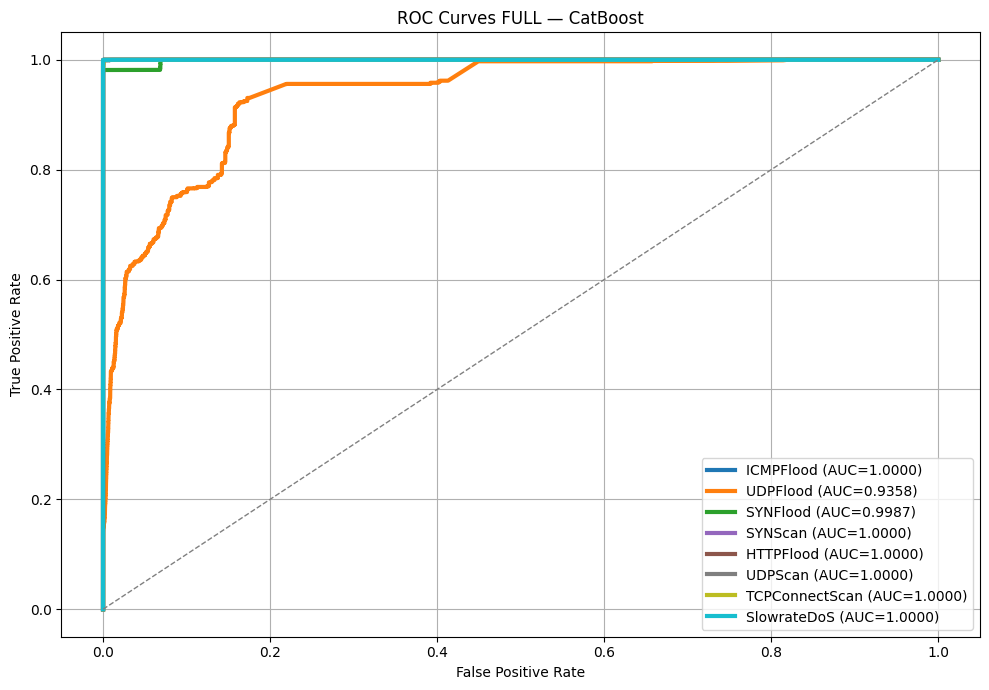

In [50]:
# =========================================
# Após o loop, gera um gráfico com todas as curvas FULL
# =========================================
plt.figure(figsize=(10, 7))
colors = plt.cm.get_cmap('tab10', len(roc_full_curves))

for i, (fpr, tpr, auc_val, label) in enumerate(roc_full_curves):
    plt.plot(fpr, tpr, lw=3, color=colors(i), label=f"{label} (AUC={auc_val:.4f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves FULL — {model_name}')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
os.makedirs("roc_curves", exist_ok=True)
plt.savefig(f"roc_curves/{model_name}_ALL_FULL_ROC.png", dpi=400)
plt.show()

In [51]:
!pip install tabulate

In [52]:
import pandas as pd
from tabulate import tabulate

df_resultados = pd.DataFrame(resultados_zero_day)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 180)
pd.set_option('display.float_format', '{:.4f}'.format)

print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═══════════════════╤════════════╤══════════╤═════════════╤══════════╤══════════════════╤═════════════╤═════════════════╤═════════════════╤═════════════════╤═══════════╤══════════════════╤═══════════════╤═══════════════════════╤══════════════════╤══════════════════════╤══════════════════════╕
│ Ataque Zero-Day   │   Acurácia │       F1 │   Precision │   Recall │   Tempo de Teste │   CPU Teste │   Memória Teste │   Energia Teste │   ZD - Acurácia │    ZD- F1 │   ZD - Precision │   ZD - Recall │   ZD - Tempo de Teste │   ZD - CPU Teste │   ZD - Memória Teste │   ZD - Energia Teste │
╞═══════════════════╪════════════╪══════════╪═════════════╪══════════╪══════════════════╪═════════════╪═════════════════╪═════════════════╪═════════════════╪═══════════╪══════════════════╪═══════════════╪═══════════════════════╪══════════════════╪══════════════════════╪══════════════════════╡
│ ICMPFlood         │   0.999746 │ 0.999791 │    0.99998  │ 0.999602 │          2.66263 │    1.01818  │         4151.1

In [53]:
df_resultados.to_csv('resultados_zero_day_formatado.csv', index=False, float_format='%.4f')